# Master equation model of the alanine dipeptide

In this example we deal with a simple but realistic example of MD simulation data, generated with the [Gromacs package](http://www.gromacs.org/).
First we import a number of general purpose Python libraries we will need as we run this example.

In [1]:
%load_ext autoreload
%matplotlib inline
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

Next, we download the relevant data from the following [location](https://osf.io/a2vc7/) 

In [2]:
from mastermsm.test.download_data import download_osf_alaTB

In [3]:
try:
    os.mkdir("test")
    download_osf_alaTB()
except FileExistsError:
    pass

### Discretizing the trajectory
We start loading the data using the data structures from the `trajectory` module. For this we use the external library [`MDtraj`](http://mdtraj.org), which contains all sorts of interesting methods for parsing and calculating interesting properties of our time-series data.

In [4]:
from mastermsm.trajectory import traj

In [5]:
tr = traj.TimeSeries(top='test/data/alaTB.gro', \
                     xtc='test/data/alaTB.xtc')
print (tr.mdt)

<mdtraj.Trajectory with 40001 frames, 19 atoms, 3 residues, and unitcells>


To extract the relevant features from the trajectory we use a Featurizer object.

In [6]:
X = traj.Featurizer(tr)

One possibility is to use the torsion angles, which we will shift for convenience.

In [7]:
X.add_torsions(shift=True)

Now our trajectories have a `features` attribute, which contains the $\phi$ and $\psi$ torsions for our amino acid residue.

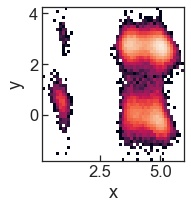

In [8]:
fig, ax = plt.subplots(1,1, figsize=(3.,3.25))
ax.hist2d(tr.features[:,0], tr.features[:,1], \
                 bins=[50, 50], norm=mpl.colors.LogNorm())
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.tight_layout()

In the following step, we will use a clustering algorithm to transform these features into discrete states. We will use the hierarchical density-based clustering algorithm called HDBSCAN.

In [9]:
DISC = traj.Discretizer(tr)
DISC.hdbscan(mcs=100)

HDBSCAN results in some datapoints being regarded as "noise". Here we use transition based assignment as originally described by Buchete and Hummer ([*J. Phys. Chem. B*, 2008](https://doi.org/10.1021/jp0761665)) to assign the trajectory to the discrete states.

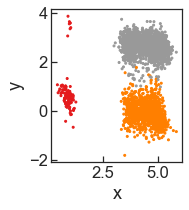

In [10]:
fig, ax = plt.subplots(1,1, figsize=(3.,3.25))
ax.scatter(tr.features[:-1:10,0], tr.features[:-1:10,1], \
           c=tr.distraj[:-1:10], s=4, cmap='Set1')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.tight_layout()

The time series data looks as follows

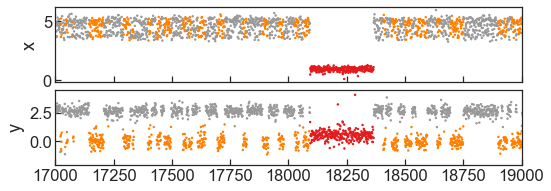

In [11]:
fig, ax = plt.subplots(2,1, figsize=(8,3), sharex=True)
ie = 20000
time = range(len(tr.features[:ie,0]))
ax[0].scatter(time, tr.features[:ie,0], \
              c=tr.distraj[:ie], s=2, cmap='Set1')
ax[1].scatter(time, tr.features[:ie,1], \
              c=tr.distraj[:ie], s=2, cmap='Set1')
ax[1].set_xlim(17000, 19000)
ax[0].set_ylabel('x')
ax[1].set_ylabel('y')
plt.tight_layout(h_pad=0)

### Making an MSM

Having assigned the trajectory to discrete states, we can now move into the estimation of the master equation (Markov state) model. First we import the `msm` module from our package

In [12]:
from mastermsm.msm import msm

We then pass the trajectory to generate an `MSM` object. A parameter we must also pass to generate this type of object is the lag time ($\Delta t$), i.e. the interval for the observation of transitions between states. In this case, we choose the smallest possible value (i.e. the timestep in our trajectory). Additionally, we use the option `sym` to enforce detailed balance in the construction in the MSM (this should be used with caution). 

In [13]:
lagt = tr.dt
msm_alaTB = msm.MSM([tr], lagt=lagt, sym=True)


 Building MSM at lag time 5


Having generated this object, we can now start calculating interesting things. First, we estimate the matrix of counts, $\mathbf{N}(\Delta t)$, i.e. the number of transitions between states and the transition matrix, $\mathbf{T}(\Delta t)$.

In [14]:
msm_alaTB.calc_count()
msm_alaTB.calc_trans()

 symmetrizing


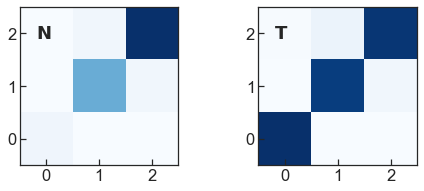

In [15]:
fig, ax = plt.subplots(1,2, figsize=(7,3))
ax[0].imshow(msm_alaTB.count, cmap='Blues', origin='lower')
ax[1].imshow(msm_alaTB.trans, cmap='Blues', origin='lower')
ax[0].text(0.1, 0.8, '$\mathbf{N}$', transform=ax[0].transAxes)
ax[1].text(0.1, 0.8, '$\mathbf{T}$', transform=ax[1].transAxes)
plt.tight_layout()

These matrices already encapsulate interesting information. Specifically, in the transition matrix we find that our three states are very metastable.

### Estimation and validation of MSMs
So far, however, we have used a value of $\Delta t$ chosen by hand. In order to correctly estimate observables like populations of states or characteristic timescales for the system, we need to be more thorough. This involves testing multiple lag times and validating the resulting models. In order to handle all these operations, `mastermsm` has an additional class, called `SuperMSM`.

In [16]:
super_alaTB = msm.SuperMSM([tr], sym=True)


 Building SuperMSM from 
 ['test/data/alaTB.xtc']


We will next try multiple lag times and compare the results

In [17]:
lags = [5, 10, 20, 50, 100, 200]
super_alaTB.do_msm(lags)
    #msm_alaTB.msms[i].calc_evals(neigs=2, errors=True, evecs=False)


 Building MSM at lag time 5
 symmetrizing

 Building MSM at lag time 10
 symmetrizing

 Building MSM at lag time 20
 symmetrizing

 Building MSM at lag time 50
 symmetrizing

 Building MSM at lag time 100
 symmetrizing

 Building MSM at lag time 200
 symmetrizing


From the multiple transition matrices, we clearly see how the number of off-diagonal terms gradually increases for higher observation windows. This is particularly clear for states 1 and 2, which interconvert rapidly.

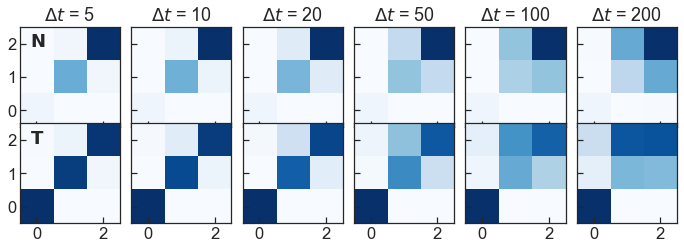

In [18]:
fig, ax = plt.subplots(2,6, figsize=(10,3.75), sharex=True, sharey=True)
for i,l in enumerate(lags):
    ax[0][i].imshow(super_alaTB.msms[l].count, cmap='Blues', origin='lower')
    ax[1][i].imshow(super_alaTB.msms[l].trans, cmap='Blues', origin='lower')
    ax[0][i].set_title('$\Delta t$ = %g'%l)
ax[0][0].text(0.1, 0.8, '$\mathbf{N}$', transform=ax[0][0].transAxes)
ax[1][0].text(0.1, 0.8, '$\mathbf{T}$', transform=ax[1][0].transAxes)

plt.tight_layout(w_pad=0, h_pad=0)

Next we compute the relaxation times and equilibrium probabilities as a function of the lag time. In this very simple case, we find that the model is apparently well converged even for the shortest value of the lag time. This is important because for long lag times ($\Delta t>10$ ps) we lose information about the fastest process.

In [ ]:
super_alaTB.calc_evals(errors=True)

In [ ]:
fig, ax = plt.subplots(2, 1, sharex=True)
for i in range(2):
    tau_vs_lagt = np.array([[x, super_alaTB.msms[x].tauT[i], \
                         super_alaTB.msms[x].tau_std[i]] \
               for x in sorted(super_alaTB.msms.keys())])
    ax[1].errorbar(tau_vs_lagt[:,0],tau_vs_lagt[:,1],fmt='o-',\
            yerr=tau_vs_lagt[:,2], markersize=4)
ax[1].fill_between(np.logspace(0.1,3.5,10), np.logspace(1, 3.5, 10),\
                facecolor='lightgray', alpha=0.5)

for i in range(3):
    peq_vs_lagt = np.array([[x, super_alaTB.msms[x].peqT[i], \
                         super_alaTB.msms[x].peq_std[i]] \
               for x in sorted(super_alaTB.msms.keys())])
    ax[0].errorbar(peq_vs_lagt[:,0], peq_vs_lagt[:,1],fmt='o-',\
            yerr=peq_vs_lagt[:,2], markersize=4)
ax[1].set_xlabel(r'$\Delta$t (ps)', fontsize=16)
ax[1].set_ylabel(r'$\tau_i$ (ps)', fontsize=16)
ax[0].set_ylabel(r'$P_{eq}$', fontsize=16)
ax[1].set_ylim(20,3000)
ax[0].set_ylim(1e-2,1)
ax[1].set_xlim(3,300)
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_xscale('log')
plt.tight_layout(h_pad=0.5)

More rigorous tests can be performed on the validity of the dynamical model.

In [ ]:
super_alaTB.ck_test(lags=[5, 10])

In [62]:
init_states = [0]

In [67]:
for lagt in [5, 10, 20]:
    time, pop = super_alaTB.msms[lagt].propagateT(init=init_states, \
                                                  time=np.logspace(1, 4, 10))

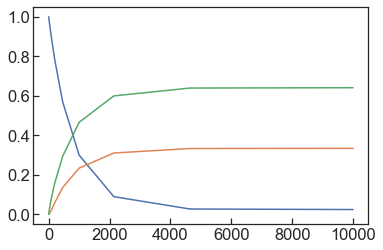

In [71]:
for i in range(3):
    plt.plot(time, [p[i] for p in pop])
for j in super_alaTB.lagts:
    plt.plot(time, super_alaTB.)

In [ ]:
pMSM_E, pMD_E, epMD_E = msm_alaTB.ck_test(time=[1, 2, 5, 7, 10, 20, 50, 100], init=['E'])
pMSM_A, pMD_A, epMD_A = msm_alaTB.ck_test(time=[1, 2, 5, 7, 10, 20, 50, 100], init=['A'])
pMSM_L, pMD_L, epMD_L = msm_alaTB.ck_test(time=[1, 2, 5, 7, 10, 20, 50, 100], init=['L'])

### Fine grid on the Ramachandran map
Alternatively we can make a grid on the Ramachandran map with many more states.

In [ ]:
tr.discretize(method="ramagrid", nbins=30)
tr.find_keys()

In [ ]:
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(tr.mdt.time, [x for x in tr.distraj], '.', ms=1)
ax.set_xlim(0, 1.5e5)
ax.set_ylim(-1, 900)
ax.set_xlabel('Time (ps)', fontsize=20)
ax.set_ylabel('state', fontsize=20)

Then we repeat the same steps as before, but with this fine grained MSM.

In [ ]:
from mastermsm.msm import msm
msm_alaTB_grid = msm.SuperMSM([tr])
for i in [1, 2, 5, 10, 20, 50, 100]:
    msm_alaTB_grid.do_msm(i)
    msm_alaTB_grid.msms[i].do_trans()
    msm_alaTB_grid.msms[i].boots()

First we take a look at the dependence of the slowest relaxation time with the lag time, $\Delta t$ for the construction of the Markov model as a minimal quality control.

In [ ]:
tau1_vs_lagt = np.array([[x, msm_alaTB_grid.msms[x].tauT[0], \
                    msm_alaTB_grid.msms[x].tau_std[0]] \
                   for x in sorted(msm_alaTB_grid.msms.keys())])
tau2_vs_lagt = np.array([[x, msm_alaTB_grid.msms[x].tauT[1], \
                    msm_alaTB_grid.msms[x].tau_std[1]] \
                   for x in sorted(msm_alaTB_grid.msms.keys())])
tau3_vs_lagt = np.array([[x,msm_alaTB_grid.msms[x].tauT[2], \
                    msm_alaTB_grid.msms[x].tau_std[2]] \
                   for x in sorted(msm_alaTB_grid.msms.keys())])
tau4_vs_lagt = np.array([[x,msm_alaTB_grid.msms[x].tauT[3], \
                    msm_alaTB_grid.msms[x].tau_std[3]] \
                   for x in sorted(msm_alaTB_grid.msms.keys())])

fig, ax = plt.subplots()
ax.errorbar(tau1_vs_lagt[:,0],tau1_vs_lagt[:,1], \
            tau1_vs_lagt[:,2], fmt='o-', markersize=10)
ax.errorbar(tau2_vs_lagt[:,0],tau2_vs_lagt[:,1], \
            tau2_vs_lagt[:,2], fmt='o-', markersize=10)
ax.errorbar(tau3_vs_lagt[:,0],tau3_vs_lagt[:,1], \
            tau3_vs_lagt[:,2], fmt='o-', markersize=10)
ax.errorbar(tau4_vs_lagt[:,0],tau4_vs_lagt[:,1], \
            tau4_vs_lagt[:,2], fmt='o-', markersize=10)
ax.fill_between(10**np.arange(-0.2,3,0.2), 1e-1, \
                10**np.arange(-0.2,3,0.2), facecolor='lightgray', alpha=0.5)
ax.set_xlabel(r'$\Delta$t [ps]', fontsize=16)
ax.set_ylabel(r'$\tau_i$ [ps]', fontsize=16)
ax.set_xlim(0.8,200)
ax.set_ylim(1,3000)
_ = ax.set_xscale('log')
_ = ax.set_yscale('log')
plt.tight_layout()

The slowest relaxation times from the fine-grained MSM agree with those of the core regions, although in this case there is an additional slow mode.

In [ ]:
fig, ax = plt.subplots()
ax.errorbar(range(1,16),msm_alaTB_grid.msms[10].tauT[0:15], fmt='o-', \
            yerr= msm_alaTB_grid.msms[10].tau_std[0:15], ms=10)
ax.set_xlabel('Eigenvalue index')
ax.set_ylabel(r'$\tau_i$ (ns)')
ax.set_yscale('log')
plt.tight_layout()

We can understand which dynamical processes the eigenvectors are associated to by looking at the corresponding eigenvectors. For this we recalculate the transition matrix but now recovering the eigenvectors. 

In [ ]:
msm_alaTB_grid.msms[10].do_trans(evecs=True)

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(12,3), sharex=True, sharey=True)
mat = np.zeros((30,30), float)
for i in [x for x in zip(msm_alaTB_grid.msms[10].keep_keys, \
                         msm_alaTB_grid.msms[10].rvecsT[:,0])]:
    #print i, i[0]%20, int(i[0]/20), -i[1]

    mat[i[0]%30, int(i[0]/30)] = i[1]
ax[0].imshow(mat.transpose(), interpolation="none", origin='lower', \
             cmap='Blues')
ax[0].set_title(r"$\psi_1$")

mat = np.zeros((30,30), float)
for i in [x for x in zip(msm_alaTB_grid.msms[10].keep_keys, \
                         msm_alaTB_grid.msms[10].rvecsT[:,1])]:
    #print i, i[0]%20, int(i[0]/20), -i[1]
    mat[i[0]%30, int(i[0]/30)] = -i[1]
ax[1].imshow(mat.transpose(), interpolation="none", origin='lower', \
             cmap='RdBu')
ax[1].set_title(r"$\psi_2$")

mat = np.zeros((30,30), float)
for i in [x for x in zip(msm_alaTB_grid.msms[10].keep_keys, \
                         msm_alaTB_grid.msms[10].rvecsT[:,2])]:
    #print i, i[0]%20, int(i[0]/20), -i[1]
    mat[i[0]%30, int(i[0]/30)] = -i[1]
ax[2].imshow(mat.transpose(), interpolation="none", origin='lower', \
                 cmap='RdBu')
ax[2].set_title(r"$\psi_3$")

mat = np.zeros((30,30), float)
for i in [x for x in zip(msm_alaTB_grid.msms[10].keep_keys, \
                         msm_alaTB_grid.msms[10].rvecsT[:,3])]:
    #print i, i[0]%20, int(i[0]/20), -i[1]
    mat[i[0]%30, int(i[0]/30)] = -i[1]
ax[3].imshow(mat.transpose(), interpolation="none", origin='lower', \
                 cmap='RdBu')
ax[3].set_title(r"$\psi_4$")

Here we are plotting the values of the eigenvectors so that the state indexes match the positions in the Ramachandran map. On the left, we show the stationary eigenvector, $\psi_1$, which is proportional to the equilibrium population. The other three plots correspond to the slowest dynamical modes. From $\psi_2$, we find that the slowest transition is the interconversion between the $\alpha_L$ and the $\alpha_R/\beta$ states. These, equilibrate more rapidly, as indicated by $\psi_3$. Finally, on the right, we find the additional mode that corresponds to a yet faster transition between the $\alpha_L$ basin and a fourth Ramachandran region.

### Clustering
So it seems three states only may not be a very good clustering for this particular system. Maybe we need one more. In order to do the clustering systematically we use the ```fewsm``` module from ```MasterMSM```. From the eigenvectors we are immediately able to produce a sensible, albeit still imperfect, partitioning in four states.

In [ ]:
from mastermsm.fewsm import fewsm

In [ ]:
fewsm4 = fewsm.FEWSM(msm_alaTB_grid.msms[2], N=4)

In [ ]:
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=(5,5))
mat = np.zeros((30,30), float)
for i in msm_alaTB_grid.msms[2].keep_keys:
    j = msm_alaTB_grid.msms[2].keep_keys.index(i)
    if j in fewsm4.macros[0]:
        mat[i%30, int(i/30)] = 1
    elif j in fewsm4.macros[1]:
        mat[i%30, int(i/30)] = 2
    elif j in fewsm4.macros[2]:
        mat[i%30, int(i/30)] = 3
    else:
        mat[i%30, int(i/30)] = 4
    #print i, i[0]%20, int(i[0]/20), -i[1]
my_cmap = cm.get_cmap('viridis')
my_cmap.set_under('w')
ax.imshow(mat.transpose(), interpolation="none", origin='lower', \
             cmap=my_cmap, vmin = 0.5)

Note how the partitioning based on eigenvectors captures the three important regions in the Ramachandran map.